<img src="https://i.imgur.com/W3mhy9f.png">

## Why does RWKV matter?

At time of writing in July 2023, the best models of language are all
[Transformers](https://jalammar.github.io/illustrated-transformer/).

Their language modeling capabilities are so strong that they can be used
for a variety of cognitive tasks, from
[agent simulation](https://arxiv.org/abs/2212.01681)
to [writing and debugging code](https://arxiv.org/abs/2305.17126).

If you joined the world of neural networks
[within the last two years](https://twitter.com/charles_irl/status/1676639200131825664),
you could be forgiven for assuming that Transformers
are an obvious type of model for language,
possibly going back to the beginnings of neural networks
[in the 1940s](https://www.cs.cmu.edu/~./epxing/Class/10715/reading/McCulloch.and.Pitts.pdf).

They are not.

Arguably the most natural model for language
is the _recurrent neural network_,
or RNN, which is
[basically "just" a map-reduce](https://colah.github.io/posts/2015-09-NN-Types-FP/#deep-learning-functional-programming).
That is, we do a `for` loop over the input,
building up a result step-by-step.

As many Python programmers
[learn early on](https://medium.com/codex/say-goodbye-to-loops-in-python-and-welcome-vectorization-e4df66615a52),
`for` loops can be unbearably slow,
and the trick to speed them up is
_vectorization_.
That is, by hand or compiler,
we rewrite the program to operate on an entire sequence at once,
instead of step-by-step.

Like vectorized programs,
Transformers being trained operate on entire sequences at once
and so are more easily parallelizable --
and so that training has been executed
at the [molar scale](https://twitter.com/charles_irl/status/1678815432487366656)
normally reserved for chemists,
not programmers.

However, that benefit does not transfer to inference time,
when we use the Transformer to generate new sequences of text --
whether to chat with a user or to drive a robot.

Instead, the choices that made the Transformer
easy to parallelize make inference expensive --
each time the model creates a new word,
it must in essence
re-read the whole sentence up to that point,
plus the new word,
before it can proceed with another.

Clever caching can
convert (re-)computation to memory storage,
but the price must be paid.

But could it be different?
Can we come up with an architecture that has Transformers'
non-negotiable parallelization at train time
but without the price at inference time?

Many alternative architectures have been proposed
since the Transformer,
from
[more efficient attention layers](https://arxiv.org/abs/2006.04768)
to
[reworked convolutional networks](https://arxiv.org/abs/2302.10866).

These alternatives generally show promising results
up to a certain scale,
say 1B parameters and 20B tokens,
or >50x less than less than
the current maximum scale for commercially
available language models at time of writing
(70B parameters, 2T tokens).

However, they have a reputation
for falling off the scaling laws
at some point shortly after.

The Receptance-Weighted Key-Value
architecture, RWKV,
has stayed on the scaling laws up to
14B parameters and 331B training tokens,
which makes it, at time of writing,
the largest-scale publicly-known
non-Transformer generative language model.
See
[the paper](https://arxiv.org/abs/2305.13048)
for details.

Through just some quick algebraic
manipulation of exponentials,
RWKV's computations can be written in either of two ways:
"time-parallel mode"
or
"RNN mode".

Essentially,
these exponentials look a bit like
the softmax normalization in Transformer attention
(`exp(w * k) v / exp(w * k)`)
in time-parallel mode
but look like a multiplicative decay
in a memory
(`exp(-tw)`)
in RNN mode.
Alternatively,
they look a bit like an unrolled loop
and its vectorized form.

So, with RWKV, we get to have our cakes and eat them too:
parallelizable training
AND efficient inference
AND Transformer-level language modeling quality.

<b> Efficient, RNN-style inference means
it's possible to run an `int8` 14B parameter RWKV model
on sequences of _any_ length with a constant memory requirement of 3GB VRAM.</b>
This opens up opportunities for language model-powered
cognitive features in tightly-constrained edge environments
with streaming inputs, like robotics,
even if RWKV turns out, like other
Transformer alternatives,
to fall off the scaling laws eventually.

This blog post walks through how RWKV's RNN-style inference works,
based on the thesis that
unvectorized code is easier to understand
and gets you most of the way to understanding
the whole system.

## Why read this post?

There are other write-ups on RWKV,
so why read this one?

It's a matter of taste!

- The
[RWKV paper](https://arxiv.org/abs/2305.13048),
uses equations to explain the architecture,
and this post uses Python code.
The code is woven into the explanatory text,
[literate programming style](https://www.youtube.com/watch?v=C8kDPmb_IKU).
If you'd like to execute and edit that code
while reading, check out the Google Colab version
[here](https://tfs.ai/rwkv-explainer-colab).
It's also aimed at experts,
and this post starts from the beginning
on autoregressive language modeling.

- The (excellent)
[blog post on RWKV by contributor Johan Wind](https://johanwind.github.io/2023/03/23/rwkv_details.html)
on which this post is based
also interweaves code with text
and is aimed at a broad audience,
but it
is written in numpy.
That makes a lot of the state-handling explicit
and is great if you're familiar with that library,
but the code looks quite different from an implementation
in PyTorch, which is more typically used to implement
neural networks like RWKV.

- The
[reference PyTorch implementation](https://github.com/BlinkDL/ChatRWKV/blob/main/RWKV_in_150_lines.py)
is written for concision
(single-letter variable names, minimal comments)
and robustness (numerical tricks).
The implementation in this post is written to be understood
and sacrifices performance for clarity,
e.g. including runtime type checking,
but produces identical results.

One last note on style and audience:
this is most definitely a tutorial!

**If you're already friendly with Transformers and
in a hurry,
feel free to skip down to the
"zero-layer RWKV" section.**

## Setup

Since we're writing real code that runs in
[an executable Colab notebook](https://tfs.ai/rwkv-explainer-colab),
not pseudocode,
we've got to do a bit of setup.

### Dependencies and Utilities

There's nothing too interesting here -- we'll talk about the libraries as they come up.

In [1]:
# Colab comes with lots of packages already -- see https://research.google.com/colaboratory/local-runtimes.html
# install a package for handling text input to the model
%pip install -qqq tokenizers==0.13.3 1> /dev/null
# install packages for runtime typechecking of arrays, more on this later!
%pip install -qqq beartype==0.14.1 jaxtyping==0.2.20 1> /dev/null
# install a neat little package for visualizing PyTorch graphs
%pip install -qqq torchview==0.2.6 1> /dev/null


# bring in some utilities from a GitHub gist
!wget --quiet https://tfs.ai/rwkv-explainer-utils -O utils.py

import utils  # useful stuff that distracts from the main points about RWKV and LMs
from utils import LoadingMixin, display_graph, make_graph, prep_weights

### Configuring Torch

We'll implement RWKV in PyTorch,
a popular Python wrapper around fast
tensor math and automatic differentiation
in C++.

In [2]:
import torch

But we're just talking about RWKV during inference,
not training,
so we don't need the differentiation.

In [3]:
torch.autograd.set_grad_enabled(False);

We use double-precision (64 bit) floating point numbers in our tensor math,
accepting a big slow-down
so that we can totally ignore numerical stability in favor of clarity.

This is a tutorial, so our brains are the rate-limiting component, not the machines!

In [4]:
torch.set_default_dtype(torch.float64)

### Downloading and Setting Up Weights

Like other neural networks,
a trained RWKV model is defined in terms of a large number
of floating point numbers,
called the "weights" or "parameters" of the model.

We want our outputs to
1) look like real language and
2) be comparable to [the reference implementation](https://github.com/BlinkDL/ChatRWKV/blob/main/RWKV_in_150_lines.py),
so we pull down those trained weights for the 430M parameter RWKV-4 model.

In [5]:
from pathlib import Path

weights_path = Path("RWKV-4-Pile-430M-20220808-8066.pth")

if not weights_path.exists():
    !wget -q https://huggingface.co/BlinkDL/rwkv-4-pile-430m/resolve/main/{weights_path.name} 1> /dev/null

print(f"Loading {weights_path}")
weights = torch.load(weights_path, map_location="cpu")

weights = prep_weights(weights)

Loading RWKV-4-Pile-430M-20220808-8066.pth


## Defining the External Interface: Strings and Tokens

We're going to work "backwards" from the model's external interface
to its internals.

So we'll spend a bit of time up front on language modeling in general.

If the phrase "Like a Transformer LM, an RWKVLM is an autoregressive probabilistic model of sequences of linear embeddings from a vocabulary of tokens" makes sense to you, you can skim this section
and the next. Jump back in at the "zero-layer RWKV" section.

If not, let's make it make sense!

### Tokenizer: the string-token and token-string interface

For our model, a _language_ is a collection of sequences
of _tokens_ from a _vocabulary_ --
you might think of the tokens as letters
from the alphabet "vocabulary"
forming sentences in the English language,
or bytes forming valid strings.


It's be great if our tokens
[were just the bytes in strings](https://arxiv.org/abs/2105.13626),
so we could just use strings as the interface
between the world of language and our model,
but the tokens for the most capable language models,
including this version of RWKV, aren't quite so simple --
they are collections of letters that appear together frequently.


So to define our tokens,
we need to construct a `Tokenizer`,
a sort of "baby language model"
that works directly on bytes/letters
and feeds its outputs to the "real language model".

In the cell below,
we pull down the `Tokenizer` that goes with RWKV-4 430M.

In [6]:
from tokenizers import Tokenizer

tokenizer_path = Path("20B_tokenizer.json")

if not tokenizer_path.exists():
    !wget -q https://raw.githubusercontent.com/BlinkDL/ChatRWKV/main/{tokenizer_path.name} 1> /dev/null

tokenizer = Tokenizer.from_file(str(tokenizer_path))

The tokenizer can encode and decode `str`ings as sequences of `int`egers
identifying tokens in our vocabulary.

In [7]:
from collections.abc import Callable

tokenizer.token_to_id: Callable[[str], int]

That last line is a
[type annotation](https://realpython.com/lessons/type-hinting/) --
by itself it doesn't do anything other than document something.
In this case, it's saying that `.token_to_id` is
- a `Callable` method
- that takes in `[]` a `str`ing
- and returns an `int`eger.

Like this:

In [8]:
id = tokenizer.token_to_id("Drosophila")

id

37815

We can also convert back to a string with our `Tokenizer`

In [9]:
print(tokenizer.id_to_token(id))

Drosophila


So the `Tokenizer` handles both ends of the outermost interface for our model:
it translates between the strings that humans (and traditional software!) like
and our token identifiers.

The vocabulary always has a specific, finite size.

For us, it's ~50,000:

In [10]:
N_VOCAB = 50_277

token_id = N_VOCAB + 10
if 0 <= token_id < N_VOCAB:
    assert tokenizer.id_to_token(N_VOCAB) is None
    print(f"index {token_id} is in vocab")
else:
    assert tokenizer.id_to_token(N_VOCAB) is None
    print(f"index {token_id} is not in vocab")

index 50287 is not in vocab


So we can identify a token identifier with just a single integer.

That's not a great way to represent
data for a neural network,
so we'll need to do another transformation
before we're ready to hand things off.

Why is an integer not a great input?

Neural networks are
[trained using calculus](https://www.youtube.com/watch?v=MDL384gsAk0&list=PLD80i8An1OEGZ2tYimemzwC3xqkU0jKUg&index=4),
so they need something smoother, like `float`s.

And they work best when there are a lot of numbers,
aka on an array or `Tensor` with large dimensions.

So let's convert our token-identifying integers into `Tensor`s full of `float`s.

PyTorch gives us the tools we need to dynamically
manipulate `Tensor`s in Python using fast compiled C++ code.
Great!

Unfortunately, providing good types for dynamic tensors is hard
(for the curious: you need type-level arithmetic, variadic generics, and more).

So there isn't great support built into the Python type system
or into PyTorch itself.

So let's pull in a typing library,
`jaxtyping`, to get some nice `Tensor` types.

In [11]:
from jaxtyping import Float64

Float = Float64  # convenient type synonym, good for easily switching float types later

Because our vocabulary is a fixed size,
there's a neat, if somewhat wasteful, way to represent the token id `ii` as a `Tensor`:
make a big `Tensor` with `0`s everywhere except in the index `ii`,
which is `1`.

This is called a `One`-`Hot` representation, and it is a kind of "sparse" tensor -- one that's mostly zeros.

In [12]:
OneHot = Float[torch.Tensor, f"vocabSize={N_VOCAB}"]

OneHot

jaxtyping.Float64[Tensor, 'vocabSize=50277']

Notice that our type includes some nice metadata,
documenting its size and what that size means.

We're going to need `OneHot`s a lot,
so let's define a function to create them:

In [13]:
def to_onehot(k: int) -> OneHot:
    out = torch.zeros(N_VOCAB)
    out[k] = 1.
    return out

to_onehot(1)

tensor([0., 1., 0.,  ..., 0., 0., 0.])

That type annotation is nice documentation of the intended interface
for this function.

But the
[best documentation is automatically checked](https://twitter.com/bernhardsson/status/1682162391574880256?s=20)
so that it stays in sync with the code it documents.

So let's bring in a runtime type checker!
That way you know you can trust
the type signatures you're reading.

We'll use `beartype`:

In [14]:
from beartype import beartype, roar

to_onehot = beartype(to_onehot)

try:
    print(to_onehot("hey"))
    assert False, "the code in this blog post is wrong!"
except roar.BeartypeCallHintException:
    print("🐻 rawr! that input type is not allowed")

try:
    print(to_onehot(N_VOCAB - 1))
except roar.BeartypeCallHintException:
    assert False, "the code in this blog post is wrong!"

🐻 rawr! that input type is not allowed
tensor([0., 0., 0.,  ..., 0., 0., 1.])


In some places, we'll use `int`s as the `Id`entifiers of our `Token`s.
In others, we'll use the `OneHot` tensor.

So we define a type that is either an `int` or (`|`) a `TokenId`.

In [15]:
TokenId = int | OneHot

TokenId

int | jaxtyping.Float64[Tensor, 'vocabSize=50277']

### `AutoregressiveLM`: a token-token interface for language modeling

Now that we can convert from strings to tokens,
we have the inputs to our language model.

To understand the output of our language model,
we need to be a bit more precise about what it does.

Language models are probabilistic.
They can make _inferences_ about sequences of tokens.
For example, they can predict which word is missing from a sequence
or which word might come next if it were to continue.

That means our model deals in chance or plausibility,
not deterministic outcomes.
We will output `Probabilities`.

An _autoregressive language model_
uses the beginning of a sequence to predict the `Next` `Token` in the sequence.

RWKVLM is an autoregressive language model,
so it will output `NextTokenProbabilities` --
a tensor with a probability for each element of the vocab,
representing the model's estimate of the chance
that token comes next in the sequence.

In [16]:
NextTokenProbabilities = Float[torch.Tensor, f"vocabSize={N_VOCAB}"]

NextTokenProbabilities

jaxtyping.Float64[Tensor, 'vocabSize=50277']

With these in hand,
we can define the behavior of an `Autoregressive` `L`anguage `M`odel:

In [17]:
class AutoregressiveLM(torch.nn.Module):
    """An LM that can continue a sequence by generating one token at a time."""

    @beartype
    def generate(self, sequence: str="", N: int=1, temperature=1.0, top_p=1.0) -> NextTokenProbabilities:
        """Generates N additional tokens that might follow the provided sequence."""

        token_ids = tokenizer.encode(sequence).ids

        if not (sequence_length := len(token_ids)):  # handle empty sequence
            probs: NextTokenProbabilities = self(0)  # 0 is a special token id, marks a boundary

        for ii in range(sequence_length + N):
            if ii < sequence_length:  # at first, tokens come from the sequence
                token = token_ids[ii]
            else:  # then after that, we're generating new tokens
                token = utils.sample(probs, temperature=temperature, top_p=top_p)

            # we get the probabilities for the next token by calling the model on the current token
            probs: NextTokenProbabilities = self(token)

            # and print the sequence as we go
            utils.streaming_print(tokenizer.decode([token]))

        return probs

<small> The `temperature` and `top_p` parameters are included
so that we can match the typical generation interface
for models like OpenAI's GPT-4 and Anthropic's Claude,
but the details don't matter to us today,
so we've abstracted them behind the `utils.sample` function. </small>

At the core, we're just doing in Python what we said in English above:
predicting the next token in a sequence repeatedly,
based on what we've seen so far,
by calling the model (`self`)
on the latest `token`.

You might wonder how our model knows
about the past of the sequence,
since we're just calling it with the current `token`.

The key is that we're inheriting from `torch.nn.Module` here.

A `Module` is like a function, in that its main purpose is to be called,
but it is also like an object,
in that it is also able to hold onto state from iteration to iteration.

That state is where we'll hold onto the parameters of the model.
It's also where we'll hold onto information about past tokens we've seen.

But, you might object,
we skipped defining what happens when the model is called!

That's true, but we can just define it now --
for a `Module`, that's done via the `forward` method:

In [18]:
@beartype
def forward(self, token: TokenId) -> NextTokenProbabilities:
    token = to_onehot(token) if isinstance(token, int) else token

    # use that onehot to retrieve the token's dense vector representation, or "embedding"
    embedded_token: Embedding = self.embedding(token)  # yes, DNN people really do say "embedding" this much

    # apply the "meat" of the model to enrich the embedding (with sequence context plus knowledge from the weights)
    sequence_embedding: Embedding = self.blocks(embedded_token)

    # use that to assign probabilities to each possible next token
    probs: NextTokenProbabilities = self.unembedding(sequence_embedding)

    return probs


# attach forward to our AutoregressiveLM class
AutoregressiveLM.forward = forward

This is a neat little pattern that Python supports but which you rarely
see outside of a notebook environment:
defining methods after the class has been defined.

We'll do this throughout the post so that we can split implementations into smaller pieces and focus on important details first.

In the cell above,
we've isolated just the `forward` method.

Right now, it's pretty abstract:
it calls some method called `embedding`
that returns an `Embedding`,
which it passes through a method called `blocks`
that returns a new `Embedding`.
That final piece is `unembed`ded
to produce the `prob`abilities we need to fit
the `AutoRegressiveLM` interface.

At this high of a level, there's no difference between an `AutoregressiveLM`
that uses Transformer-style blocks and one that uses RWKV-style blocks.

Following our "inside-out" approach,
we'll first define the `embedding` and `unembedding`,
in the next section,
before we dive into the RWKV-specific details.

We'll close out this section,
and our implementation of `AutoregressiveLM`,
by defining how it's initialized:

In [19]:
def __init__(self, embedding_layer, blocks, unembedding_layer):
    super(AutoregressiveLM, self).__init__()
    self.embedding: TokenEmbedding = embedding_layer
    self.blocks: Callable[[Embedding], Embedding] = blocks  # RWKV will go here
    self.unembedding: Unembedding = unembedding_layer

AutoregressiveLM.__init__ = __init__

## Defining the Internal Interface: `Embedding`s and `Unembedding`

Our autoregressive language model
uses this `Embedding` type as its internal representation.

Let's see how it is produced from our `TokenId`s
and how it gets turned into `NextTokenProbabilities`.

### `TokenEmbedding`: From token identifiers to dense tensors

The inputs and outputs of neural networks are often sparse tensors,
as we saw with the `OneHot`s above:
most of the entries are zeros.

But in their guts, neural networks are tensor calculus machines,
applying dense tensors of floats to dense tensors of floats.

So the "interface" inside of our network is a dense tensor --
and one much smaller than our vocabulary.

The internals of our network will all
"speak" dense tensor.

There are many other names for these dense float tensors,
but we'll stick with `Embedding` since that has taken off in the era
of embedding-based vector search for LLMs,
and we'll use `channel` to refer to an individual dimension,
because `EmbeddingDimension` is a mouthful.

Why are they called "embeddings"?
Roughly,
because they are created by taking a pointy object,
like our collection of `OneHot` tensors
that are all far away from each other
(imagine 50,000 vertices on a big cube),
and smushing them together into a smooth object.
Vicki Boykis has a great write-up
[here](https://vickiboykis.com/what_are_embeddings/).

In [20]:
N_EMBD = 1024
Embedding = Float[torch.Tensor, f"channels={N_EMBD}"]
# aka internal representation, aka hidden state, aka latents, aka "residual stream"
Embedding

jaxtyping.Float64[Tensor, 'channels=1024']

We build another `torch.nn.Module` to compute our `Embedding`s.

It has two steps: first we compute the dense vector from our `OneHot`
and then we normalize it, so that its length is always the same.

In [21]:
@beartype
def forward(self, token: TokenId) -> Embedding:
    token = to_onehot(token) if isinstance(token, int) else token
    embedded_token: Embedding = self.embedding(token)
    normalized_embedded_token = self.normalize_emb(embedded_token)

    return normalized_embedded_token

We'll be normalizing our embeddings a lot.
You might ask why.

Like with many things in neural networks,
the typical answer is
"it helps with optimization"
and the real answer is
"the thing stops working if we don't".

But how exactly do we do our normalization
and how do we get that dense vector?

PyTorch has built in `nn.Module`s for these operations,
so we can just add them to our `TokenEmbedding` `Module`
when it gets initialized.

In [22]:
def __init__(self):
    super(TokenEmbedding, self).__init__()
    self.embedding = torch.nn.Linear(in_features=N_VOCAB, out_features=N_EMBD, bias=False)
    self.normalize_emb = torch.nn.LayerNorm(N_EMBD)

Applying a `Linear` layer to a `OneHot`
just pulls out one of the columns.

The normalizer subtracts the mean and divides by the standard deviation,
which makes the length of the `Embedding` 1,
then multiplies by a number to set the length.

That number, and the values in the `Linear` layer's columns,
aren't based on the inputs.
They are "learned parameters" of the model,
learned during training.

So we need to load the values from the `weights`
that we downloaded during the setup --
which we do by adding a janky class from our `utils`,
a `LoadingMixin`

In [23]:
class TokenEmbedding(LoadingMixin, torch.nn.Module):
    """A layer that converts token IDs into vectors our network's blocks can work with."""

TokenEmbedding.__init__ = __init__
TokenEmbedding.forward = forward

which adds a `from_weights` method that we can use to create the class
directly from our `weights`.

Now we can initialize the `TokenEmbedding`
with the correct weights and take a look at it:

In [24]:
embs = TokenEmbedding.from_weights(weights)

embs

TokenEmbedding(
  (embedding): Linear(in_features=50277, out_features=1024, bias=False)
  (normalize_emb): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

Hmm, that's kind of a lame visualization.

It's nice for printing to terminal logs,
but we're in a browser,
so we can do better.

Let's use the
[`torchview` library](https://github.com/mert-kurttutan/torchview)
to get something cooler:
a trace of all the pieces of our model,
to a variety of levels of detail
(`depth` in our tree of `Module`s).

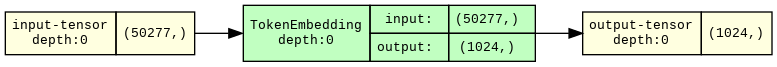

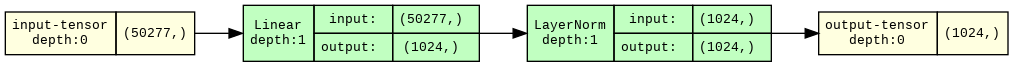

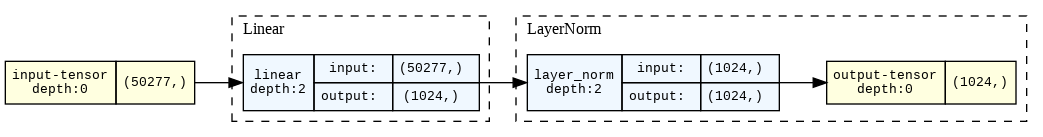

In [25]:
for depth in range(3):
    display_graph(make_graph(TokenEmbedding(), depth=depth, input_data=to_onehot(0)))

Read from top to bottom, these diagrams say:
1. This module is called `TokenEmbedding` and takes in `50_277` dimensional tensors and returns `1024` dimensional tensors.
2. That `TokenEmbedding` is made up of a `Linear` module and a `LayerNorm` module.
3. The `Linear` module calls a function named `linear`
amd the `LayerNorm` module calls a function named `layer_norm`.

### `Unembedding`: from dense vectors to token probabilities

Once we're done processing with our network,
we need to get back to a probability distribution over tokens,
which we can finally turn into specific tokens
and then strings.

The `Unembedding` layer gets us from our `Embedding`s
to `NextTokenProbabilities`:

In [26]:
class Unembedding(LoadingMixin, torch.nn.Module):
    """A layer that converts our network's internal representation into a prediction."""

    @beartype
    def forward(self, x: Embedding) -> NextTokenProbabilities:
        normalized_embedding = self.normalize_unemb(x)
        logits = self.unembedding(normalized_embedding)  # "logits" basically means "unnormalized probabilities"

        # we convert them to probabilities with the softmax function
        probs: NextTokenProbabilities = torch.nn.functional.softmax(logits, dim=-1)

        return probs

For the `Unembedding`, we use the same `Module`s
as the `TokenEmbedding`, but in reverse:

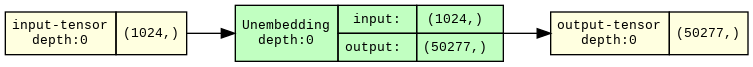

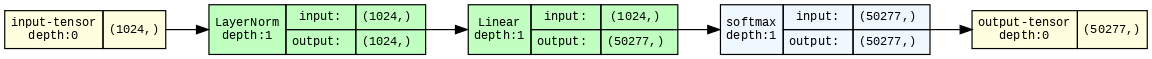

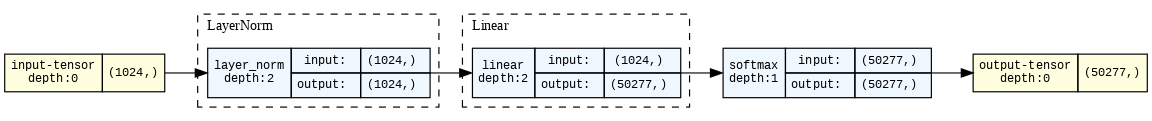

In [27]:
def __init__(self):
    super(Unembedding, self).__init__()
    self.normalize_unemb = torch.nn.LayerNorm(N_EMBD)
    self.unembedding = torch.nn.Linear(in_features=N_EMBD, out_features=N_VOCAB, bias=False)

Unembedding.__init__ = __init__

for depth in range(3):
    display_graph(make_graph(Unembedding(), depth=depth, input_data=torch.zeros(N_EMBD)))

And that's it for the `Unembedding` --
we just need to load in the weights.

In [28]:
unembs = Unembedding.from_weights(weights)

Now we can translate from our model's `Embedding`s
to the `Tokenizer`'s vocabulary
and from there to strings for humans!

## A "`marwkv`" model: zero-layer RWKV

The simplest RWKV model has no blocks in the middle --
just embedding and unembedding.

It's equivalent (up to those pesky normalization layers)
to the
[zero-layer Transformer](https://transformer-circuits.pub/2021/framework/index.html#zero-layer-transformers).

It's entirely linear --
all adds and multiplies --
so it's actually a type of
logistic regression!

And, because it has no way
to track or store information over time,
it predicts the next token
from just the most recent token.

A model that can only see the present value
when generating the next is known as a
[_Markov chain_](https://en.wikipedia.org/wiki/Markov_chain).

So, never ones to miss a good pun,
we'll call it the maRWKV model.

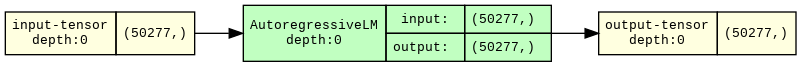

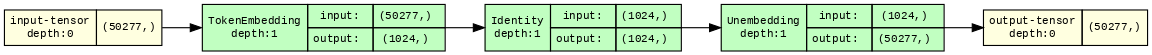

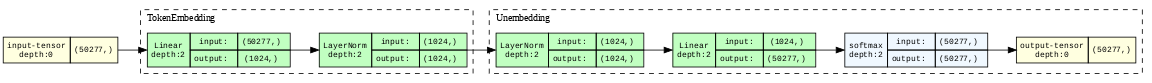

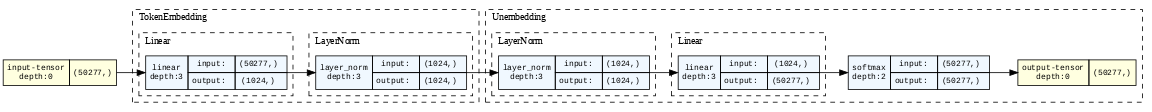

In [29]:
marwkv = AutoregressiveLM(
    embs,
    torch.nn.Identity(),  # do nothing
    unembs
)


for depth in range(4):
    viz_marwkv = AutoregressiveLM(TokenEmbedding(), torch.nn.Identity(), Unembedding())
    display_graph(make_graph(viz_marwkv, depth=depth, input_data=to_onehot(0)))

Let's see what happens when we run it.

Let's take a nice long token from the vocab -- `Drosophila`,
the [genus of fruit flies](https://en.wikipedia.org/wiki/Drosophila).

In [30]:
marwkv.generate("Drosophila", N=1, temperature=0.0);  # temperature == 0 means just take the most likely token

Drosophila melan

Nice! That looks like the beginning of the rest of the scientific name of _Drosophila melanogaster_,
the [dark-bellied](https://en.wiktionary.org/wiki/melanogaster#Latin)
fruit fly species used in genetic research.

Let's keep going:

In [31]:
marwkv.generate("Drosophila", N=2, temperature=0.0);

Drosophila melanospor

Oh dear! That's not `melanogaster`!

`melanospor` is the beginning of another frequently-used scientific name:
`melanosporum`, the species name of the [French black truffle](https://en.wikipedia.org/wiki/Tuber_melanosporum).


A Markov chain is like a game of telephone:
each token is generated only with knowledge
of the one immediately previous.

This gives Markov language models a decidely "free-association" energy.

And "Drosophila melanosporum" is the scientific nomenclature equivalent of
"Harry Potter-y Barn" or "Saddam Hussein Obama".

How can we do better?

## Defining Internal Computation and Propagation: Gated MLP and Attention

For better language generation, we need two things:
- More layers, so that we can do more complex processing on each token
- More context, so information is preserved from more than just the previous token

The RWKV blocks we add will do both!

To fit multiple `RWKVBlock`s into our `AutoregressiveLM` interface,
which expects just one `Module`
(and one which maps `Embedding`s to `Embedding`s)
in the middle,
we'll combine them
using `torch.nn.Sequential`.

Really, we end up just calling them one after the other:

In [32]:
class RWKV(LoadingMixin, torch.nn.Module):

    @beartype
    def forward(self, x: Embedding) -> Embedding:
        for ii, block in enumerate(self.blocks):
            x = block(x)
        return x

    def __init__(self, rwkv_blocks: list):
        super().__init__()
        self.blocks = torch.nn.Sequential(*rwkv_blocks)

Before defining those `blocks`,
let's get a clearer picture of just what is meant by
"doing more complex processing" and "adding more context".

This is best seen from an example, which we take from
Figure 9 in the appendix of
[the RWKV paper](https://arxiv.org/abs/2305.13048),
reproduced below,
which shows how the model
produces the token _Paris_
to continue the sequence
_The Eiffel Tower is located in the city of_.

<small> For more on how this plot is made, see
[the original paper on "causal tracing"](https://arxiv.org/abs/2202.05262).</small>

![RWKV Figure on information propagation](https://i.imgur.com/VEA1b5j.png)

The horizonal axis is what we just added with
the `RWKV` class's `blocks` --
as we move from left to right in the graph,
a given token is being processed
by more and more blocks.

The vertical axis is "time", aka "sequence length"
or the "sequence dimension".
As we move from top to bottom,
a token is being processed in the context
of more and more tokens.

Each time we apply our model to a token,
all of the model's layers are applied --
we move through a row of the graph.

The figure shows that the fact that Eiffel Tower
is in the city of Paris
arises in an early layer:
observe the dark purple color
in the row for the _el_ token,
beginning at layer 4/5 or so.

Put another way,
the `Embedding` for the _el_ token
has been "enriched" with additional information:
that jumble of floating point numbers now expresses
that the noun phrase this token is part of
refers to an object in the city of Paris.

Enriching tokens with information about the world
from outside the sequence is done primarily by the MLP
modules in a Transformer.
In RWKV, that will be done by a similar module,
a `GatedMLP`.

Later tokens in the sequence, like _city_,
do not have this information in them --
nor should they!
Despite what some Francophiles might claim,
not all cities are Paris.

Instead, that information is first
propagated deeper into the network:
see the purple line moving from left to right.

At some point, that information
does need to be transferred to later tokens --
at the very least,
it needs to make it to the final token
in the sequence to get added to the
`NextTokenProbabilities`.

We can see that in roughly layer 20:
follow the purple vertical line downwards
from the _el_ token to the _of_ token.
From there the information
that the Eiffel Tower is in Paris
propagated to the output.

Routing information across time is the responsibility
of the `Attention` modules of a Transformer.
We'll give the same name to the module that
achieves the same outcome in RWKV,
even though it works quite a bit more like a memory:
information is added to _all future embeddings_.

Let's put that all together:

In [33]:
class RWKVBlock(torch.nn.Module):
    """The core "block" in the RWKV architecture, which updates the embedding."""

    @beartype
    def forward(self, x: Embedding) -> Embedding:
        # attention enriches embedding using sequence memory
        dx: Update = self.attention(self.ln1(x))
        x: Embedding = x + dx  # preserve inputs as much as possible

        # gated MLP enriches embedding by doing computations
        dx: Update = self.gated_mlp(self.ln2(x))
        x: Embedding = x + dx  # again, preserve inputs

        return x

Okay, we slipped in a `l`ayer `n`ormalization,
which is important but uninteresting.

But what is an `Update`?

It's just a synonym for `Embedding`!

In [34]:
Update = Embedding
Update

jaxtyping.Float64[Tensor, 'channels=1024']

Again, we're using the type hints for documentation --
it helps us separate which `Tensor`s are used for what.

Now, let's define how our `Block` gets initialized:

In [35]:
def __init__(self):
    super(RWKVBlock, self).__init__()
    self.ln1 = torch.nn.LayerNorm(N_EMBD)
    self.attention = AttentionBlock()

    self.ln2 = torch.nn.LayerNorm(N_EMBD)
    self.gated_mlp = GatedMLP()


RWKVBlock.__init__ = __init__

The `LayerNorm`s we recognize.

For the other layers, let's just put in placeholders,
like we did for the RWKV blocks in the zero-layer model,
so that we can visualize our architecture again
and focus on the overall flow.

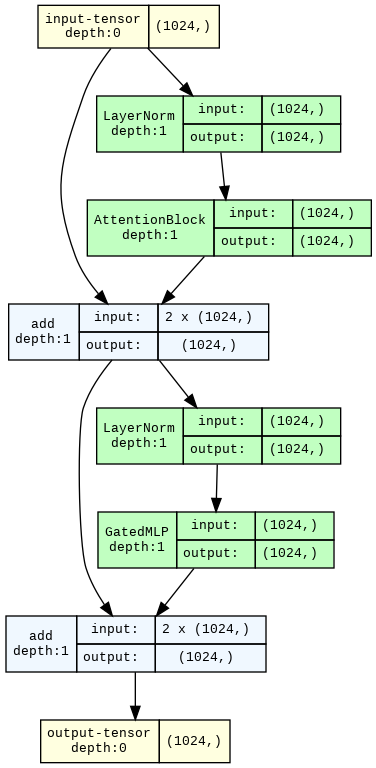

In [36]:
class GatedMLP(torch.nn.Identity):
    """Placeholder"""

class AttentionBlock(torch.nn.Identity):
    """Placeholder"""

display_graph(make_graph(RWKVBlock(), input_data=torch.zeros(N_EMBD), depth=1, graph_dir="TD"))

Follow that arrow on the left --
it connects the input to the output with only additions.

This is a _residual connection_,
which is also a
[very important feature of Transformers](https://transformer-circuits.pub/2021/framework/index.html).

This residual connection is one reason why we could
we could just rip out the entire middle of the network
and still get reasonable outputs:
each layer ends up just adjusting the output of the previous layer,
rather than starting from scratch,
so the inputs of the first block
and the outputs of the last block
are similar enough that the
unembedding at the end can read either!

It's also important, like our normalization layers,
for stabilizing optimization.

### The Gated MLP

Alright, now let's dive into the implementation of the simpler
of the two components in the block, the `GatedMLP`.

The `MLP` part is pretty standard
and looks like the same part of
the Transformer
but uses non-standard nomenclature --
the input layer's weights are called `key` weights
and the output layer's weights are called `value` weights.

The other two pieces,
the `mixer`s and the `gating`,
are less standard.

We'll define them below.

In [37]:
from torch import sigmoid


class GatedMLP(torch.nn.Module):
    """Applies an MLP (matrix, nonlinearity, matrix) with gated outputs."""

    @beartype
    def forward(self, x: Embedding) -> Update:
        # "mix" current input with the previous input
        mixed_x: Embedding = self.mlp_mixer(x)
        # put that through an MLP
        mlp_outputs: Embedding = self.value(self.nonlinearity(self.key(mixed_x)))
        # non-standard nomenclature, probably because of this paper https://arxiv.org/abs/2012.14913

        # "mix" the current input with the previous input again, with different weights
        mixed_x_receptance: Embedding = self.receptance_mixer(x)
        # use that to calculate how "receptive" each dimension of embedding is to new inputs
        receptance: Embedding = self.receptance(mixed_x_receptance)

        # convert that receptance to a 0-1 value with a sigmoid
        gating_values: Embedding = sigmoid(receptance)
        # then use those as "gating" by multiplying them
        dx: Update = gating_values * mlp_outputs

        return dx

The `receptance`/`gating` is not present in the MLP
portion of a Transformer.
It's
[more of an RNN thing](https://arxiv.org/abs/1412.3555).

If you graph it, the `sigmoid` function
is shaped like an elongated _s_,
with the bottom left of the s at
`(-inf, 0)` and the top-right at `(inf, 1)`.
It turns the `receptances`,
which can be any floating point number,
into multiplicative `gating_values`,
numbers that are between `0` and `1`.

When the `gating_value` for a channel is close to `0`,
the value of `dx` in that channel for the `GatedMLP` is
also close to `0`.
Effectively, we don't `Update` that channel of the `Embedding`
with the MLP's output.

Essentially, the `mlp_output` computation
decides what _might_ be returned,
and the `receptance` decides _whether_ it's returned.

Now, let's talk `mixer`s.

At multiple points in the RWKV architecture,
information from the current embedding
is mixed with information from the most recent embedding.

This is important when inividual tokens in the language
are not very meaningful,
e.g. when you're working directly with bytes,
rather than with `Tokenizer`s
that have tokens like `Drosophila`.

The mixers are probably not a
critical feature of the architecture,
but they're there
and working through an implementation
will help us practice handling state in PyTorch,
so let's go for it!

Here's the `forward` -- notice
how we use the `last_x` value as part of our calculations
and assign the `current_x` value to that variable
before we finish.

In [38]:
class Mixer(LoadingMixin, torch.nn.Module):
    """Returns a per-entry-weighted combination of current input and previous input."""

    @beartype
    def forward(self, current_x: Embedding) -> Embedding:
        out =  mix_embeddings(current_x, self.last_x, self.weight)
        self.last_x: Embedding = current_x  # store for later
        return out

The specific way these mixers combine embeddings
is by a weighted combination.

The weights are _per-channel_,
i.e. different dimensions of the embedding
get mixed differently.

In [39]:
ChannelParameter = Float[torch.Tensor, f"params={N_EMBD}"]  # one parameter for each embedding dimension

@beartype
def mix_embeddings(x: Embedding, y: Embedding, mixing_params: ChannelParameter) -> Embedding:
    """Mixes two embeddings with weights given by the mixing_params."""
    return x * mixing_params + y * (1 - mixing_params)

mix_embeddings

<function __main__.mix_embeddings(x: jaxtyping.Float64[Tensor, 'channels=1024'], y: jaxtyping.Float64[Tensor, 'channels=1024'], mixing_params: jaxtyping.Float64[Tensor, 'params=1024']) -> jaxtyping.Float64[Tensor, 'channels=1024']>

Now, let's write an `init`
for the `Mixer` class.

Handling the weights is easy enough --
we've had parameters in many of our `Module`s,
but they've been handled for us by PyTorch,
like in `Linear` and `LayerNorm`.

We just need to explicitly assign a `torch.nn.Parameter`
to store our mixing weights.

But what about the `last_x`?
It's not exactly a `Parameter`,
but we still need to store it.

We can use `register_buffer` to store extra, non-`Parameter` information in our `torch.nn.Module` --
it's very similar to creating a `Parameter`,
but interacts differently with gradients during training.

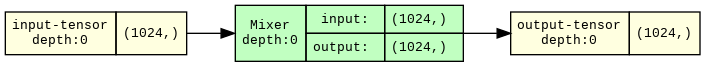

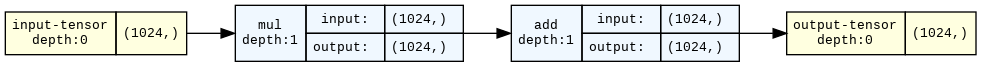

In [40]:
def __init__(self):
    super(Mixer, self).__init__()
    self.weight = torch.nn.Parameter(torch.zeros(N_EMBD))
    self.register_buffer("last_x", torch.zeros(N_EMBD), persistent=False)  # persistent=False means "don't save to disk"

Mixer.__init__ = __init__

for depth in range(2):
    display_graph(make_graph(Mixer(), input_data=torch.zeros(N_EMBD), depth=depth))

Note that the buffers and parameters don't show up in the graph!
It only shows the tensors we input or produce,
not the ones we store.

Now, we can round out our `GatedMLP` implementation with an `init`:

In [41]:
MLP_HIDDEN_DIM = 4096  # note: 4 x N_EMBD

def __init__(self):
    super(GatedMLP, self).__init__()
    # again, non-standard terminology of RWKV: "key" is first layer of MLP, "value" is second
    self.key = torch.nn.Linear(N_EMBD, MLP_HIDDEN_DIM, bias=False)
    self.nonlinearity = SquaredReLU()  # non-standard nonlinearity
    self.value = torch.nn.Linear(MLP_HIDDEN_DIM, N_EMBD, bias=False)

    self.mlp_mixer, self.receptance_mixer = Mixer(), Mixer()
    self.receptance = torch.nn.Linear(N_EMBD, N_EMBD, bias=False)

GatedMLP.__init__ = __init__

Oh, one more thing, the `nonlinearity` in the middle of the MLP is non-standard too.

It's the usual `ReLU` layer, but with the output `Squared`:

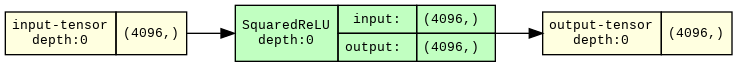

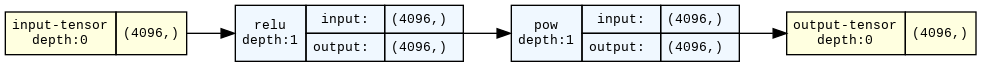

In [42]:
Latents = Float[torch.Tensor, f"latents={MLP_HIDDEN_DIM}"]

class SquaredReLU(torch.nn.Module):
    def forward(self, x: Latents) -> Latents:
        return torch.nn.functional.relu(x) ** 2

for depth in range(2):
    display_graph(make_graph(SquaredReLU(), input_data=torch.zeros(MLP_HIDDEN_DIM), depth=depth))

That's a complete implementation,
so we can take a look at the graph.

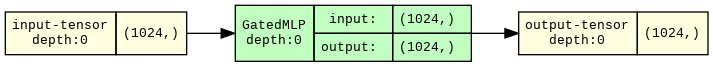

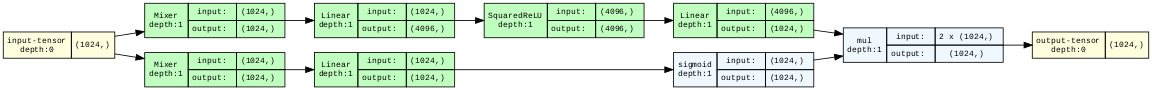

In [43]:
for depth in range(2):
    display_graph(make_graph(GatedMLP(), depth=depth, input_data=torch.zeros(N_EMBD)))

We can see the two mixers on the far left.

The one on the top feeds into a linear-nonlinear-linear cascade --
that's the `MLP`.

The one on the bottom feeds into a sigmoid before being multiplied --
that's the `Gated` part.

### The "Attention" Block

With that warm-up done,
let's tackle the harder of the two pieces:
the "attention" block
that handles information routing over time.



For this one, let's start with the `__init__`.

We've got a bunch of `Linear` layers,
which again go by the names `key` and `value` and `receptance`,
plus one more to determine our final `output`.

We've also got matching `Mixer`s for the `key`s, `value`s, and `receptance`s.

The only really new piece is the `WKVMemory`.


In [44]:
class AttentionBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # linear operations
        self.key = torch.nn.Linear(N_EMBD, N_EMBD, bias=False)
        self.value = torch.nn.Linear(N_EMBD, N_EMBD, bias=False)
        self.receptance = torch.nn.Linear(N_EMBD, N_EMBD, bias=False)
        self.output = torch.nn.Linear(N_EMBD, N_EMBD, bias=False)

        # mixers
        self.key_mixer, self.value_mixer = Mixer(), Mixer()
        self.receptance_mixer = Mixer()

        # memory
        self.memory: torch.nn.Module = WKVMemory()

#### The secret sauce: `WKVMemory`

But it's a big piece!

The memory is the heart of the architecture,
and it's both very different from
any component of a Transformer
and fairly complicated.

But, as a wise model once said,
["let's work this out in a step-by-step way to be sure we have the right answer"](https://arxiv.org/abs/2211.01910).

We'll start with the components,
which we define in the `init`.

As with the mixers, we have some parameters
that operate on channels
and we have some persistent state to track.

In [45]:
class WKVMemory(torch.nn.Module):
    """A memory module whose contents exponentially decay over time, at a different rate per channel."""
    def __init__(self):
        super().__init__()

        # learned memory parameters -- one value for each dimension in the embeddings
        self.log_gain: ChannelParameter = torch.nn.Parameter(torch.zeros(N_EMBD))
        self.log_decay: ChannelParameter = torch.nn.Parameter(torch.zeros(N_EMBD))

        # state buffers to track information across a sequence
        contents, normalizer = torch.zeros(N_EMBD), torch.zeros(N_EMBD)
        self.register_buffer("contents", contents, persistent=False)
        self.register_buffer("normalizer", normalizer, persistent=False)

The names for these parameters,
`gain` and `decay`,
come from signal processing.

A `gain` is used to attenuate or amplify a signal.
We'll use it only on the current embedding,
so our memory can treat it specially,
relative to the stored information.

A `decay` parameter determines the rate at which a signal attenuates over time.
We'll use it on the information stored in the memory
so that it goes away over time -- fading towards `0`.

The memory has two pieces of state to track:

- the `contents` track
the information observed so far,
accumulating over time

- they're unnormalized,
so we also track a `normalizer`
for those `contents`.

The final "state of" or "information in"
the memory is their ratio,
`contents / normalizer`.

As part of a forwards pass,
we update both,
so our "memory" is some kind of average across time
of what we've seen so far.

Here's what that looks like:

In [46]:
from typing import Tuple

ScalingWeight = Float[torch.Tensor, f"positiveEntries={N_EMBD}"]  # positive number, one per channel

@beartype
def update(self, importances: ScalingWeight, values: Embedding) -> Tuple[Update, Update]:
    """Updates the memory by incrementing time and mixing in the weighted input values."""
    # decay the information currently in memory by one step
    self.step()

    # compute new information to add to the memory
    contents_update: Update = importances * values  # scale each value by the matching importance weight
    normalizer_update: Update = importances  # keep track of the weights so we can normalize across steps

    # and then add the new information to the memory
    self.contents += contents_update
    self.normalizer += normalizer_update # -- including updating the normalizer!

    # and return it
    return contents_update, normalizer_update


WKVMemory.update = update

Without the decay step,
the ratio of `contents` and `normalizer`
would be just a _weighted average_ of past values.

That is,
for each channel, we're accumulating (`+=`)
the weighted `values` into the `content` and
the `weights` into `normalizer`,
and `contents/normalizer` is
their ratio: the weighted average.

But once we include the decay `step`,
each channel in the memory
becomes an _exponential moving_ weighted average:

In [47]:
from torch import exp


def step(self):
    """Pushes the information currently in the memory towards zero."""
    decay_rate: ScalingWeight = exp(self.log_decay)  # exp ensures that decay rate is positive
    self.contents *= exp(-decay_rate)  # decay_rate > 0, so exp(-decay_rate) < 1
    self.normalizer *= exp(-decay_rate)  # so each .step shrinks the contents and normalizer towards 0


WKVMemory.step = step

That is, we repeatedly multiply
the `contents` (and their `normalizer`!)
with a number between 0 and 1,
determined by our `decay_rate`.

If a channel had an infinitely large `decay_rate`,
its state would just be the most recent `value`
in that channel.

Channels with very large decay rates are common
early in the network.

If it had a `decay_rate` of 0,
the channel would go back to being a weighted average.

That allows for longer-term integration of information,
and channels with very low decay rates are common
later in the network.

Now let's look at the full `forward` pass for the memory.

It's almost as simple as
- update the memory
- return the memory's state, aka `contents / normalizer`

but there's one small complication --
the `gain`, which
gets applied to just the most recent value.

The `gain` ensures that the most recent value
is treated differently than all past values.

Here's what that looks like:

In [48]:
@beartype
def forward(self, values: Embedding, importances: ScalingWeight) -> Update:
    """Applies the RWKV "time-mixing block" forward pass, in the "RNN Cell" style.

    For details, see https://arxiv.org/abs/2305.13048, Appendix B, Eqn. 19-22 and Fig. 7."""
    # first, we update the memory and return what we just added
    latest_contents, latest_normalizer = self.update(importances, values)

    # then, we adjust the representation of the latest information
    latest_contents, latest_normalizer = self.apply_gain(latest_contents, latest_normalizer)

    # before adding it in and dividing, to get the final thing we report as output
    out: Update = (self.contents + latest_contents) /           \
                  (self.normalizer + latest_normalizer)

    return  out


WKVMemory.forward = forward

By the way, this is where we hit the numerical instability
that requires us to use `float64` in this implementation.
We are taking exponents (dangerous)
and dividing them (doubly dangerous).

The official implementation uses
several tricks to remove this instability and
allow the use of lower precision floats,
but they add a lot of complexity to code
that's already pretty tough to follow.

To finish out our implementation of `WKVMemory`,
let's add the `gain`:

In [49]:
def apply_gain(self, latest_contents, latest_normalizer):
    """Applies the channelwise gain to the latest contents and normalizer."""
    gain = exp(self.log_gain) - 1  # -1 < gain < inf

    boosted_contents = gain * latest_contents
    boosted_normalizer = gain * latest_normalizer

    return boosted_contents, boosted_normalizer


WKVMemory.apply_gain = apply_gain

When the gain parameter for a channel is
at its lowest value, `-1`,
applying it removes the update we added.
That channel is always "one step behind"
and its output only reflects the past --
useful for spreading information across tokens.

<small>This way of writing it is another source of
numerical instability in this implementation:
we add and then subtract,
which is unfortunately not quite the same
as doing nothing when floats are involved.</small>

When the gain for a channel is very large,
the output of the memory is always the same
as the input value in that channel --
much like having a very large `decay_rate`.

When the gain for the channel is close to `0`,
the current value is treated the same as past values.

The graph representation isn't particularly helpful
for the `WKVMemory`,
because this `Module` doesn't have any sub-modules.

But if you look closely, you can see the memory updates.
They're the `add_` operations --
`_` means "in-place" in PyTorch.

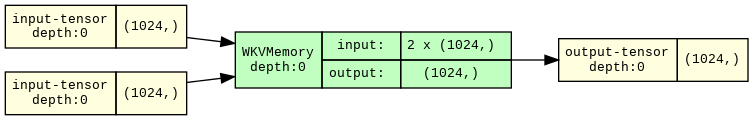

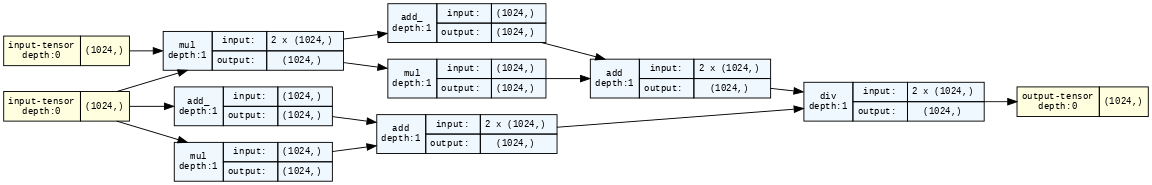

In [50]:
for depth in range(2):
    display_graph(make_graph(WKVMemory(), depth=depth, input_data=(torch.zeros(N_EMBD), torch.zeros(N_EMBD))))

#### The rest of the `AttentionBlock`

Let's see how the memory gets incorporated into the `AttentionBlock`.

In short, we
- calculate the `keys` and `values`, after running the `Mixer`s,
- use the `exp`onentiated `keys` as weights to store the `values` in the `memory`,
- calculate `gating` for our memory's output based on `receptance`s, and finally
- use one more `Linear` layer to calculate our final `Update`.

Which looks like this:

In [51]:
@beartype
def forward(self, x: Embedding) -> Update:
    # as with the MLP, do mixers before anything else
    mixed_keys = self.key_mixer(x)
    keys: Embedding = self.key(mixed_keys)

    mixed_values = self.value_mixer(x)
    values: Embedding = self.value(mixed_values)

    # wkv: apply "w"eighted decay to merge
    #      current info ("k"eys and "v"alues) with past
    wkv: Embedding = self.memory(values, exp(keys))

    # decide how "r"eceptive each channel is to inputs
    mixed_receptances = self.receptance_mixer(x)
    receptances: Embedding = self.receptance(mixed_receptances)
    gating_values = sigmoid(receptances)

    # rwkv: use the "r"eceptances to gate the output of the "wkv" memory
    rwkv: Embedding = gating_values * wkv

    # and then do one final linear transform before returning it
    dx: Update = self.output(rwkv)

    return dx

AttentionBlock.forward = forward

The graph view, below, is a helpful summary
of the flow in this block.

The three `Mixer`s-with-`Linear`-transformations appear first.

One is used via `sigmoid`-then-`mul` to gate the rest --
that'd be the `receptances`.

The other two are used in the `WKVMemory` --
but the `keys` are first `exp`onentiated into importance weights.

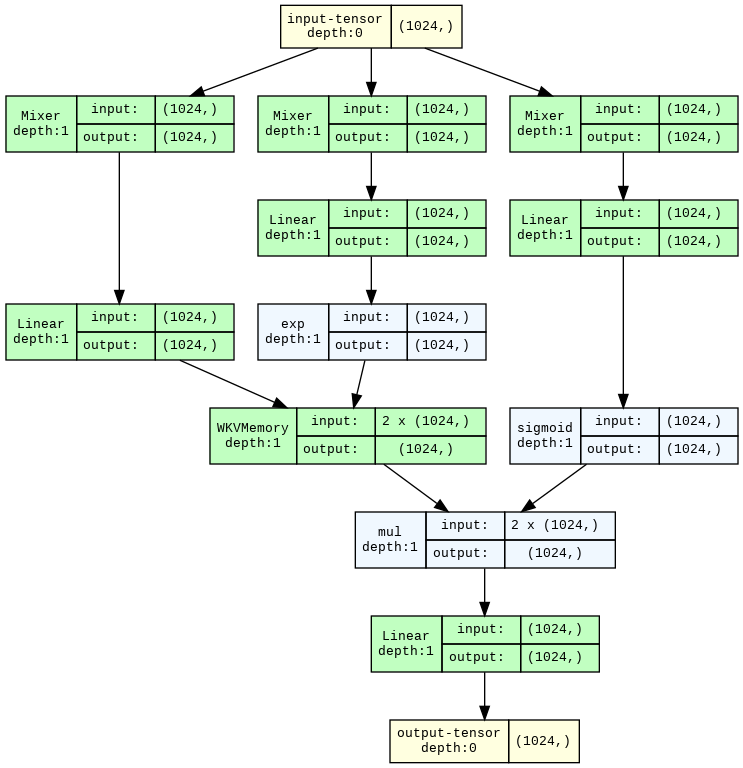

In [52]:
display_graph(make_graph(AttentionBlock(), depth=1, input_data=torch.zeros(N_EMBD), graph_dir="TD"))

Notice that there are no "queries" --
there's nothing we compare to the `keys`
to decide which `values` are important.

That makes this very different from Transformer attention,
which looks a lot more like a lookup from a key-value store --
so much so that you can implement it
[in Redis](https://colab.research.google.com/drive/1QC3XgiuTaryc4hipKcJG6aYeXZ0hVqtT?usp=sharing),
a popular key-value database.

Instead, determining what is relevant as
we proceed through the sequence,
aka deciding what's worth our attention,
is split into deciding _what to store in memory right now_
and _what from our memory is relevant right now_.

1. We decide what to store in our memory by calculating `values` and assigning them importances
via the (`exp`onentiated) `keys`.
2. We decide what's relevant right now
by using the `receptances` to filter
the `wkv` memory.

Hence `rwkv`.

<b>This is the core of what makes RWKV's inference
easier on the RAM than Transformer inference:
we explicitly store information from the past,
rather than looking the information up
from the past every time we need it!</b>

It also makes the memory a bottleneck,
which is one reason why you might suspect
that a model like RWKV might not
be as capable as a Transformer of the same size.

That
[hasn't been the case up to 14B parameters](https://arxiv.org/abs/2305.13048),
but scale can reveal hidden issues!

That said, 14B parameters is big enough
to get some pretty useful behavior
out of a language model,
so with RWKV, efficient-inference LMs
have already secured a spot in the language modeling tech stack!

## Putting it all together

Let's see what the graph view looks like for an entire `RWKVBlock`.

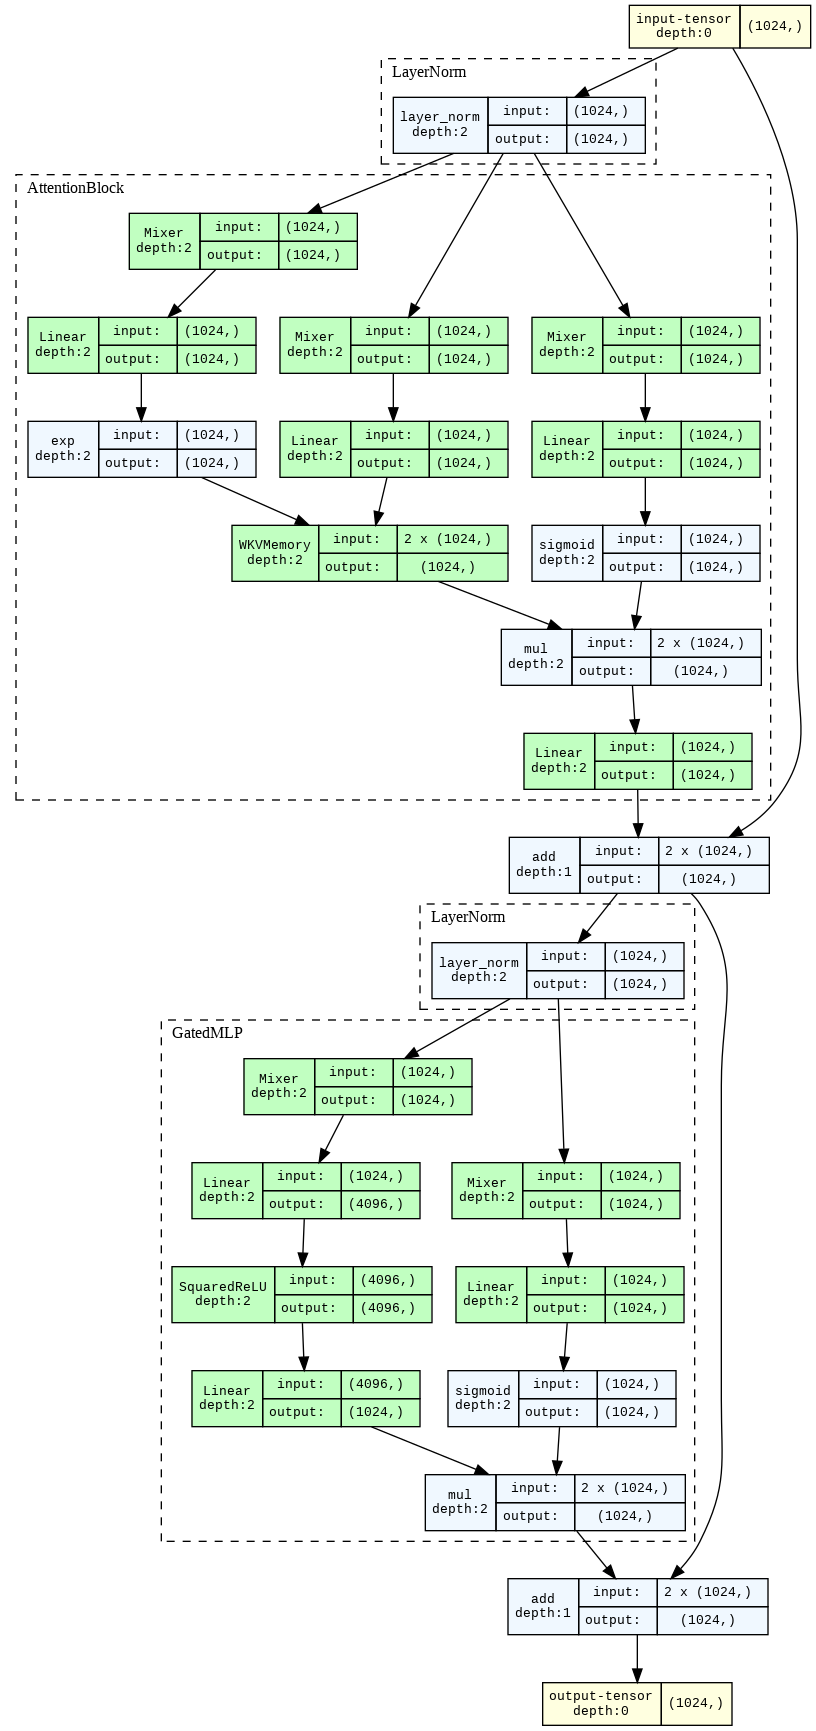

In [53]:
display_graph(make_graph(RWKVBlock(), depth=2, input_data=torch.zeros(N_EMBD), graph_dir="TD"))

What could be simpler?



But in all seriousness:
these graphs can be very helpful adjuncts to the code!

To really grok this architecture,
I recommend pulling one of the graphs up in a separate window
and mapping it onto the matching module's code.


Now, let's run a few layers and see if the added ability to store information about past tokens
solves the `Drosophila melanosporum` problem.

In [54]:
k = 2
short_rwkv = RWKV.from_weights(weights, [RWKVBlock() for _ in range(k)])
short_rwkvlm = AutoregressiveLM(embs, short_rwkv, unembs)
short_rwkvlm = short_rwkvlm.eval()

out = short_rwkvlm.generate(sequence="Drosophila", N=2, temperature=0.0)

Drosophila melanog

Success! We're starting to get the rest of "melanogaster",
the expected following token.


But we've got one more thing to handle:
we've written how to add state to the memory
and the mixers,
but we haven't written any way to remove information,
so our model will just accumulate information forever,
and we'd need to reinitialize it
if we wanted to start "fresh"
on a new sequence.

Let's add a quick helper to clear out state:

In [55]:
def clear_buffers(module, verbose=False):
    for name, buffer in module.named_buffers():
        if verbose:
            print(f"clearing buffer {name}")
        buffer.zero_()


AutoregressiveLM.clear_buffers = clear_buffers
RWKV.clear_buffers = clear_buffers
RWKVBlock.clear_buffers = clear_buffers

## Running a "real" model: RWKV-4 430M

Okay, so we can run a toy model
with a few layers
and get three tokens in a row to make sense.

That's cool,
but what about the entire RWKV-4 430M model
whose weights we've been using?

Let's close our examination of RWKV inference with that!

First we initialize it:

In [56]:
N_LAYER = 24
rwkv_blocks = [RWKVBlock() for _ in range(N_LAYER)]

rwkv = RWKV.from_weights(weights, rwkv_blocks)

rwkv4 = AutoregressiveLM(embs, rwkv, unembs)
rwkv4 = rwkv4.eval()

And then we run it:

In [57]:
rwkv4.clear_buffers()

out = rwkv4.generate(sequence="Drosophila", N=8, temperature=0.0)

Drosophila* and *Drosophila melanogaster*

Interestingly, it starts adding some Markdown formatting --
scientific names are usually written *Like this*,
which is formatted in Markdown `*Like this*`.

Lastly, let's confirm
that the model can generate
reasonable text.

More than that, let's check that
it outputs _the same text_ as
[the official reference](https://github.com/BlinkDL/ChatRWKV/blob/main/RWKV_in_150_lines.py)!

This is the main test I used to
check that my implementation was really equivalent.

In [58]:
rwkv4.clear_buffers()

sequence = """
In a shocking finding, scientist discovered a herd of dragons living in a remote, previously unexplored valley, in Tibet. """ + \
"Even more surprising to the researchers was the fact that the dragons spoke perfect Chinese."

rwkv4.generate(sequence, N=20, temperature=0.0);


In a shocking finding, scientist discovered a herd of dragons living in a remote, previously unexplored valley, in Tibet. Even more surprising to the researchers was the fact that the dragons spoke perfect Chinese.

The dragons were discovered by a team of researchers from the University of California, Berkeley, who

[Go Bears](https://dailycal.org/2019/10/14/go-bears-rallying-cry-or-meme).